In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [5]:
os.listdir('.')
# os.chdir('drive/My Drive/Colab_Test/Dataset/Time-Series Prediction')

['sales.csv', 'birth.csv', 'daily-min-temperatures.csv', 'shampoo.csv']

In [6]:
def parser(x):
  return pd.datetime.strptime(x, '%Y-%m')

In [7]:
dataset = pd.read_csv('sales.csv',header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
dataset.head()

Month
1960-01-01     6550
1960-02-01     8728
1960-03-01    12026
1960-04-01    14395
1960-05-01    14587
Name: Sales, dtype: int64

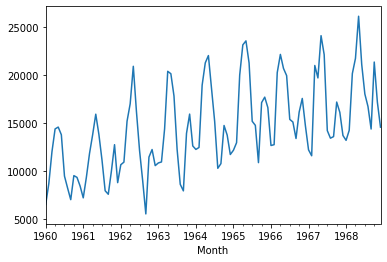

In [ ]:
dataset.plot()
plt.show()

#Dari plot diatas, terdapat Trend dan Seasonality pada kasus ini

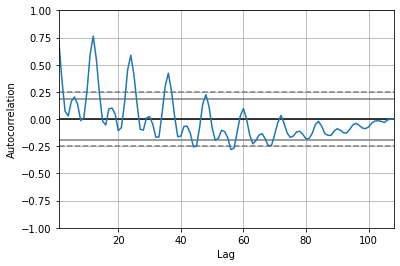

In [ ]:
pd.plotting.autocorrelation_plot(dataset)
plt.show()

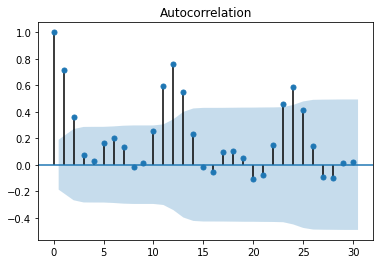

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(dataset, lags=30, ax=plt.gca())
plt.show()

# [0, 1, 2, 11, 12, 13, 23, 24]

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# ARIMA (Auto Correlation Integrated Moving Average)

In [ ]:
model = ARIMA(dataset, order = (2, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                  107
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1016.733
Method:                       css-mle   S.D. of innovations           3238.735
Date:                Thu, 17 Sep 2020   AIC                           2041.466
Time:                        11:02:04   BIC                           2052.157
Sample:                    02-01-1960   HQIC                          2045.800
                         - 12-01-1968                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            76.5216    324.843      0.236      0.814    -560.158     713.201
ar.L1.D.Sales     0.1764      0.096      1.845      0.068      -0.011       0.364
ar.L2.D.Sales    -0.1413      0.096     

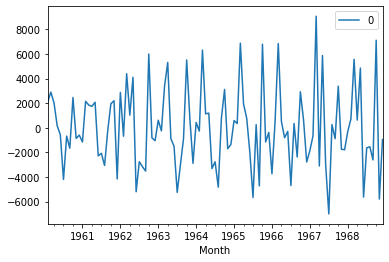

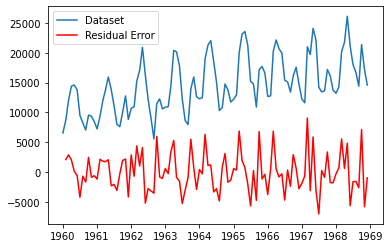

In [ ]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

plt.plot(dataset)
plt.plot(residuals, color='red')
plt.legend(['Dataset', 'Residual Error'])

In [ ]:
residuals

,0
Month,
1960-02-01,2101.478425
1960-03-01,2896.654509
1960-04-01,2021.045329
1960-05-01,166.129828
1960-06-01,-569.067200
...,...
1968-08-01,-1544.435068
1968-09-01,-2613.397077
1968-10-01,7111.507128


In [ ]:
print(residuals.describe())

                 0
count   107.000000
mean      3.694041
std    3254.493956
min   -7000.877106
25%   -2038.157156
50%    -303.267287
75%    1940.369505
max    9059.576217


Rolling Forecast ARIMA Model (Prediction)


In [ ]:
values = dataset.values
size = int(len(values) * 0.15)
train, test = values[0:size], values[size:len(values)]
history = [x for x in train]
predictions = []

for i in range(len(test)):
	model = ARIMA(history, order=(2,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	prediction = output[0]
	predictions.append(prediction)
	expected = test[i]
	history.append(expected)
	print('predicted=%f, expected=%f' % (prediction, expected))
error = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % error)

predicted=14792.210353, expected=15926.000000
predicted=17268.866856, expected=13821.000000
predicted=12667.107152, expected=11143.000000
predicted=10310.015140, expected=7975.000000
predicted=6556.836937, expected=7610.000000
predicted=8168.252210, expected=10015.000000
predicted=11773.545779, expected=12759.000000
predicted=13973.833914, expected=8816.000000
predicted=5442.566866, expected=10677.000000
predicted=12164.611031, expected=10947.000000
predicted=10917.683476, expected=15200.000000
predicted=16701.782629, expected=17010.000000
predicted=17582.609569, expected=20900.000000
predicted=22542.162089, expected=16205.000000
predicted=15647.493737, expected=12143.000000
predicted=11600.837274, expected=8997.000000
predicted=8186.782216, expected=5568.000000
predicted=4321.024617, expected=11474.000000
predicted=13430.458245, expected=12256.000000
predicted=12315.459144, expected=10583.000000
predicted=10210.856512, expected=10862.000000
predicted=11171.605453, expected=10965.00000

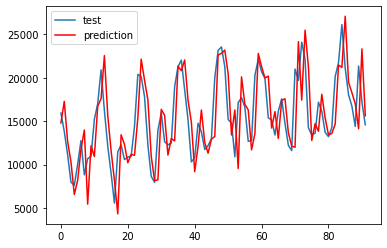

In [ ]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.legend(['test','prediction'])
plt.show()

In [ ]:
def evaluate_arima_model(dataset_values, arima_order, test_size):
	# prepare training dataset
	train_size = int(len(dataset_values) * (1-test_size))
	train, test = dataset_values[0:train_size], dataset_values[train_size:]
	test_ori = test.copy()
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		prediction = model_fit.forecast()[0]
		predictions.append(prediction)
		history.append(test[t])
	# calculate out of sample error
	rmse = mean_squared_error(test, predictions, squared=False)
	return {'rmse': rmse, 'predictions': predictions, 'test': test_ori}

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_list, d_list, q_list, test_size):
	dataset = dataset.astype('float32')
	dataset_value = dataset
	train_size = int(len(dataset_value) * (1-test_size))
	test_set = dataset_value[train_size:]
	best_score, best_cfg = float("inf"), None
	for p in p_list:
		for d in d_list:
			for q in q_list:
				order = (p,d,q)
				try:
					result = evaluate_arima_model(dataset_value, order, test_size)
					if result['rmse'] < best_score:
						best_score, best_cfg = result['rmse'], order
						# best_pred = result['predictions']
					print('ARIMA%s RMSE=%.3f' % (order,result['rmse']))
				except:
					print('ARIMA(%s, %s, %s) not working' % (p,d,q))
					continue
	if best_cfg == None:
		print("Sad")
	else:
		print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
		best_pred = evaluate_arima_model(dataset_value, best_cfg, test_size)['predictions']
		plt.plot(test_set)
		plt.plot(best_pred, color='red')
		plt.legend(['test','prediction'])
		plt.show()

ARIMA(0, 0, 0) RMSE=4628.977
ARIMA(0, 0, 1) RMSE=3516.572
ARIMA(0, 0, 2) not working
ARIMA(0, 1, 0) RMSE=3380.273
ARIMA(0, 1, 1) RMSE=3499.110
ARIMA(0, 1, 2) RMSE=3471.804
ARIMA(0, 2, 0) RMSE=5181.908
ARIMA(0, 2, 1) RMSE=3430.798
ARIMA(0, 2, 2) RMSE=3552.266
ARIMA(1, 0, 0) RMSE=3176.636
ARIMA(1, 0, 1) RMSE=3249.564
ARIMA(1, 0, 2) RMSE=2992.531
ARIMA(1, 1, 0) RMSE=3485.434
ARIMA(1, 1, 1) not working
ARIMA(1, 1, 2) not working
ARIMA(1, 2, 0) RMSE=4581.300
ARIMA(1, 2, 1) not working
ARIMA(1, 2, 2) not working
ARIMA(2, 0, 0) RMSE=3334.713
ARIMA(2, 0, 1) RMSE=3337.799
ARIMA(2, 0, 2) RMSE=2982.767
ARIMA(2, 1, 0) RMSE=3535.318
ARIMA(2, 1, 1) not working
ARIMA(2, 1, 2) not working
ARIMA(2, 2, 0) RMSE=4565.441
ARIMA(2, 2, 1) not working
ARIMA(2, 2, 2) not working
ARIMA(3, 0, 0) RMSE=3333.779
ARIMA(3, 0, 1) RMSE=2921.980
ARIMA(3, 0, 2) not working
ARIMA(3, 1, 0) RMSE=3235.930
ARIMA(3, 1, 1) not working
ARIMA(3, 1, 2) not working
ARIMA(3, 2, 0) RMSE=4409.235
ARIMA(3, 2, 1) not working
ARIMA(3, 2,

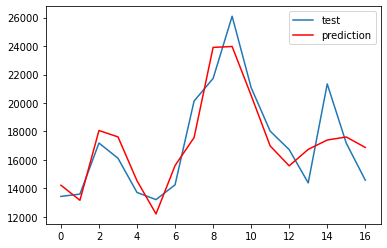

In [ ]:
import warnings

p_values = range(0, 30)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(values, p_values, d_values, q_values, 0.15)

# SARIMA (Seasonal Autoregressive Integrated Moving Average)

In [10]:
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [16]:
# Courtesy of Jason Brownlee of Machine Learning Mastery
# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [0, 1, 2]
	d_params = [0, 1]
	q_params = [0, 1]
	t_params = ['n','c','t','ct']
	P_params = [2]
	D_params = [0, 1]
	Q_params = [0, 1]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models

In [17]:
n_test = 12

# model configs
cfg_list = sarima_configs()

# grid search
scores = grid_search(dataset.values, cfg_list, n_test)
print('done')

# list top 3 configs
for cfg, error in scores[:3]:
  print(cfg, error)

done
